In [1]:
SEED = 42

Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install dependencies

In [3]:
!pip install livelossplot -q

# Imports

In [4]:
import tensorflow as tf
from pathlib import Path
from os.path import abspath
import pandas as pd
import os
from livelossplot import PlotLossesKeras

available_gpus = tf.config.list_physical_devices('GPU')
print(f"Number of available GPUs: {len(available_gpus)}")

try:
    tf.config.experimental.set_memory_growth(available_gpus[0], True)
except:
    pass

Number of available GPUs: 1


# Paths

In [5]:
SRC_DIR = Path('/content/drive/MyDrive/TAI/III/nlp/')
DATA_DIR = SRC_DIR / "data"
LOG_DIR = SRC_DIR / 'logs'
BEST_MODEL_DIR = LOG_DIR / "checkpoints"
TENSOR_BOARD_DIR = LOG_DIR / "tensor_board"

# Dataset

## Load dataset

In [6]:
dataset_df = pd.read_csv(os.path.join(DATA_DIR, "dataset.csv"))

## Dataset info

In [7]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105354 entries, 0 to 105353
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               105354 non-null  int64 
 1   followers_count  105354 non-null  int64 
 2   verified         105354 non-null  bool  
 3   reactions_count  105354 non-null  int64 
 4   retweet_count    105354 non-null  int64 
 5   text             105354 non-null  object
 6   source           105354 non-null  object
 7   description      89892 non-null   object
 8   replies_count    105354 non-null  int64 
 9   fake             105354 non-null  bool  
dtypes: bool(2), int64(5), object(3)
memory usage: 6.6+ MB


In [8]:
dataset_df.head()

,id,followers_count,verified,reactions_count,retweet_count,text,source,description,replies_count,fake
0,498254340310966273,1080,False,53,286,Michael Brown is the 17 yr old boy who was sho...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True
1,498260814487642112,1639,False,1,1,@AmeenaGK @jaythenerdkid And how long before a...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True
2,498261272174284801,6612,False,0,0,@d_m_elms @AmeenaGK they'll drag his entire hi...,"<a href=""http://twitter.com/download/android"" ...",muslim cis queer neuroatypical intersectional ...,0,True
3,498261302733967361,1070,False,1,2,@d_m_elms @jaythenerdkid or traces back some b...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True
4,498261642099326976,1639,False,5,9,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True


In [9]:
dataset_df['fake'].value_counts()

False    72229
True     33125
Name: fake, dtype: int64

Duplicates and NaNs

In [10]:
dataset_df.duplicated().sum()

0

In [11]:
dataset_df.isnull().sum()

id                     0
followers_count        0
verified               0
reactions_count        0
retweet_count          0
text                   0
source                 0
description        15462
replies_count          0
fake                   0
dtype: int64

## Clean data

### Drop NaNs

In [12]:
dataset_df = df = dataset_df.fillna('')

## Map type to int

In [13]:
mapping = {False: 0, True: 1}
dataset_df['class'] = dataset_df['fake']
dataset_df = dataset_df.replace({'class': mapping})

## Merge title and text

In [14]:
dataset_df['text_combined'] = dataset_df['text'] + ' ' + dataset_df['description']

In [15]:
dataset_df.head()

,id,followers_count,verified,reactions_count,retweet_count,text,source,description,replies_count,fake,class,text_combined
0,498254340310966273,1080,False,53,286,Michael Brown is the 17 yr old boy who was sho...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True,1,Michael Brown is the 17 yr old boy who was sho...
1,498260814487642112,1639,False,1,1,@AmeenaGK @jaythenerdkid And how long before a...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True,1,@AmeenaGK @jaythenerdkid And how long before a...
2,498261272174284801,6612,False,0,0,@d_m_elms @AmeenaGK they'll drag his entire hi...,"<a href=""http://twitter.com/download/android"" ...",muslim cis queer neuroatypical intersectional ...,0,True,1,@d_m_elms @AmeenaGK they'll drag his entire hi...
3,498261302733967361,1070,False,1,2,@d_m_elms @jaythenerdkid or traces back some b...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True,1,@d_m_elms @jaythenerdkid or traces back some b...
4,498261642099326976,1639,False,5,9,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True,1,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...


## Split dataset to train, val and test

Function

In [16]:
from sklearn.model_selection import train_test_split

# separate data into data and labels
features = dataset_df['text_combined']
targets = dataset_df['class']

# splitting data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=SEED)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=SEED)


In [17]:
predicted_frame = pd.DataFrame(X_test)
predicted_frame['index_column'] = predicted_frame.index
predicted_frame

,text_combined,index_column
82242,@huseinifaysal @DanieleRaineri AQ have mention...,82242
5442,@elonjames Evening news will show why. Capture...,5442
65369,@ChannelNewsAsia Marlene Kairouz MP | Member f...,65369
11846,@TorontoStar R.I.P. ☀️,11846
19284,“@abcnews: Two women have emerged from the Lin...,19284
...,...,...
97817,@ChrChristensen @ioerror he was reduced to hun...,97817
63413,Happy to oblige\n\n@demonnick666 @BasimaFaysal...,63413
68755,@MariamVeiszadeh @OTOTGo @anggerwitasari Stay ...,68755
10329,@cnnbrk praying that no more innocent people w...,10329


### Convert X, y to tensors

In [18]:
X_train =  tf.constant(X_train, dtype=tf.string)
X_test =  tf.constant(X_test, dtype=tf.string)
X_val =  tf.constant(X_val, dtype=tf.string)

In [19]:
y_train = tf.constant(y_train, dtype='float32')
y_test = tf.constant(y_test, dtype='float32')
y_val = tf.constant(y_val, dtype='float32')

# Model

## Parameters

In [22]:
BATCH_SIZE = 64
EPOCHS = 100
VOCABULARY_SIZE = 100000
MAX_SEQUENCE_LEN = 300
EMBEDDING_DIM = 75

## Vectorization layer

In [23]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize='lower',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LEN,
)
vectorize_layer.adapt(X_train, batch_size=BATCH_SIZE)

## Model architecture

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 300, 75)           7500000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              208896    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 7,709,153
Trainable params: 7,709,153
Non-trainable params: 0
_________________________________________________________________


## Metrics

In [25]:
METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc'),
    ]

## Compile

In [26]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics= METRICS
)

## Callbacks

In [27]:
BEST_MODEL_FILE = BEST_MODEL_DIR / "bidirectional_lstm_default_params"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.001, restore_best_weights=True)
save_best = tf.keras.callbacks.ModelCheckpoint(filepath=BEST_MODEL_FILE, monitor='val_loss', save_best_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(filename=LOG_DIR / "history_bidirectional_lstm_default_params.csv")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=str(TENSOR_BOARD_DIR.resolve()))

## Train

In [28]:
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[save_best, early_stop, csv_logger],
    )

Epoch 1/100
1317/1317 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.8500 - recall: 0.6957 - precision: 0.8007 - auc: 0.9190

1317/1317 [==============================] - 128s 85ms/step - loss: 0.3299 - accuracy: 0.8500 - recall: 0.6957 - precision: 0.8007 - auc: 0.9190 - val_loss: 0.2519 - val_accuracy: 0.8889 - val_recall: 0.8013 - val_precision: 0.8412 - val_auc: 0.9547
Epoch 2/100
1317/1317 [==============================] - ETA: 0s - loss: 0.1614 - accuracy: 0.9305 - recall: 0.8919 - precision: 0.8874 - auc: 0.9814

1317/1317 [==============================] - 63s 48ms/step - loss: 0.1614 - accuracy: 0.9305 - recall: 0.8919 - precision: 0.8874 - auc: 0.9814 - val_loss: 0.2485 - val_accuracy: 0.8899 - val_recall: 0.8392 - val_precision: 0.8187 - val_auc: 0.9581
Epoch 3/100
1317/1317 [==============================] - 48s 36ms/step - loss: 0.0936 - accuracy: 0.9617 - recall: 0.9420 - precision: 0.9366 - auc: 0.9936 - val_loss: 0.3050 - val_accuracy: 0.8890 - val_recall: 0.8174 - val_precision: 0.8305 - val_auc: 0.9535
Epoch 4/100
1317/1317 [==============================] - 45s 34ms/step - loss: 0.0526 - accuracy: 0.9789 - recall: 0.9662 - precision: 0.9665 - auc: 0.9978 - val_loss: 0.3556 - val_accuracy: 0.8821 - val_recall: 0.8255 - val_precision: 0.8076 - val_auc: 0.9476
Epoch 5/100
1317/1317 [==============================] - 45s 34ms/step - loss: 0.0321 - accuracy: 0.9872 - recall: 0.9786 - precision: 0.9806 - auc: 0.9992 - val_loss: 0.4276 - val_accuracy: 0.8827 - val_recall: 0.7845 - val_prec

## Plot metrics history

In [29]:
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, metric_names):
  for n, metric in enumerate(metric_names):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()



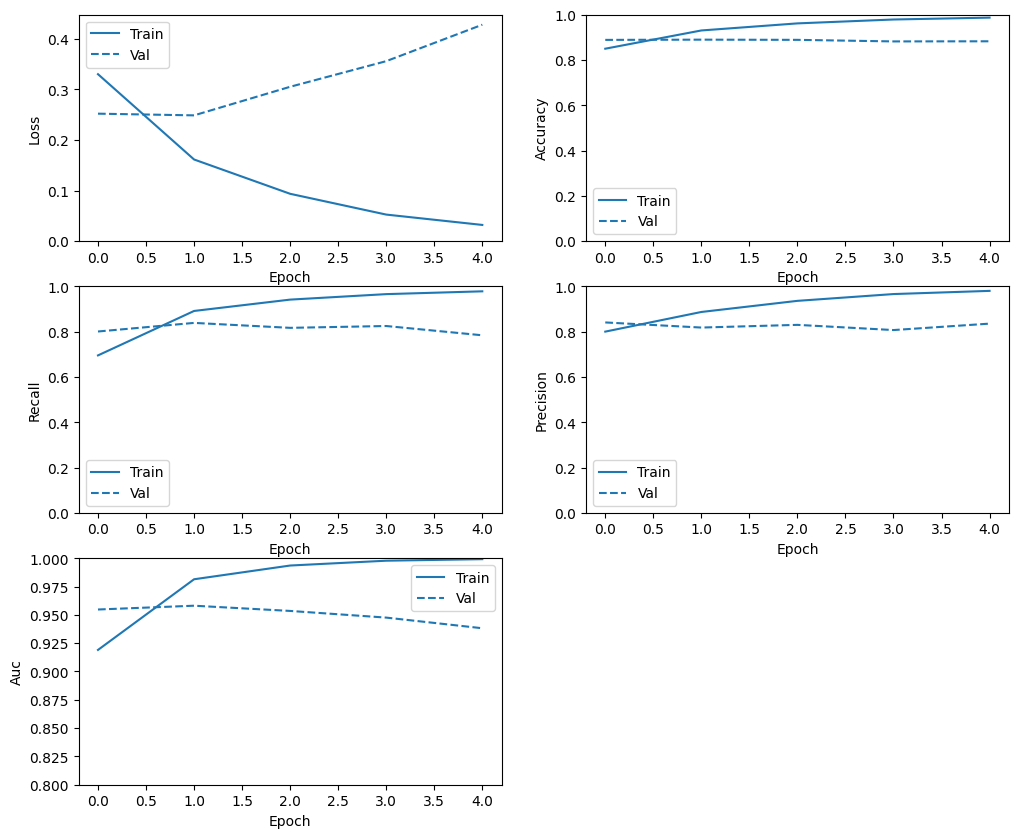

In [30]:
metrics = ["loss", 'accuracy', 'recall', 'precision', 'auc']
plt.figure(figsize=(12,10))
plot_metrics(history, metrics)

# Evaluation

In [31]:
model.evaluate(X_test, y_test)

330/330 [==============================] - 4s 11ms/step - loss: 0.2411 - accuracy: 0.8925 - recall: 0.8525 - precision: 0.8127 - auc: 0.9600


[0.2411346435546875,
 0.8924537301063538,
 0.8524590134620667,
 0.8127351403236389,
 0.9600251317024231]

 Load best model and save predictions

In [20]:
model = tf.keras.models.load_model(BEST_MODEL_DIR / "bidirectional_lstm_default_params")

In [21]:
preds = model.predict(X_test)

330/330 [==============================] - 11s 10ms/step


In [22]:
predicted_frame['preds'] = preds
predicted_frame['true'] = y_test
predicted_frame.drop(columns='text_combined', inplace=True)
predicted_frame.to_csv('/content/drive/MyDrive/TAI/III/nlp/preds_dataframes/bidirectional_lstm_default_params.csv')
predicted_frame

,index_column,preds,true
82242,82242,0.069354,0.0
5442,5442,0.733886,1.0
65369,65369,0.184826,0.0
11846,11846,0.853257,1.0
19284,19284,0.999036,1.0
...,...,...,...
97817,97817,0.000036,0.0
63413,63413,0.001366,0.0
68755,68755,0.000011,0.0
10329,10329,0.581048,1.0
